# Recurrent Neural Network (RNN)

Human language is sequential. A word is a sequence of letters, a sentence is a sequence of words, and a paragraph is a sequence of sentences. One key aspect of human language is that the meaning of a word depends on the context. For example, the word "bank" has different meanings in the sentences "I went to the bank to deposit money." and "I went to the bank to catch fish." Human can understand the contextual nuance because they can maintain a "working memory" that captures information from previous words.
This is the core idea of Recurrent Neural Networks (RNNs).


## The Core Idea

Imagine reading a book while maintaining a "summary" in your mind that you update with each new sentence. This is similar to how RNNs work. Operationally, RNNs process a sequence of inputs $(x_1, x_2, \ldots, x_T)$ one at a time, updating a *hidden state* $h_t$ that acts as a "working memory" that captures information from previous inputs.

$$ h_t = f(x_t, h_{t-1}) $$

This captures the essence of RNNs: the current hidden state ($h_t$) depends on both the current input ($x_t$) and the previous hidden state ($h_{t-1}$).
Function $f$ is a neural network that takes the current input and the previous hidden state as input and outputs the current hidden state.

```{note}
Think of the hidden state as a "working memory" that's constantly being updated. Just as you might remember key plot points while reading a novel but forget minor details, the hidden state learns to maintain relevant information for the task at hand.
```

## Model

```{figure} ../figs/rnn.jpg
:alt: RNN Model
:width: 500px
:align: center

A recurrent neural network (RNN) showing both architectural views. Left: Compact representation where NN processes input $x_t \in \mathbb{R}^n$ and hidden state $h_t \in \mathbb{R}^d$ to produce output $o_t \in \mathbb{R}^m$. Right: Expanded view showing the concatenation $[x_t, h_{t-1}]$, linear transformations ($W, b_h$), and $\tanh$ activation. Colors indicate corresponding components: inputs (blue), hidden states (green), outputs (pink), and transformations (yellow).
```

The forward pass of an RNN processes sequential data through a series of transformations as follows:

1. The RNN first combines the current input vector $x_t \in \mathbb{R}^n$ and the previous hidden state $h_{t-1} \in \mathbb{R}^d$ to form a new vector.

    $$
    v_t = [x_t, h_{t-1}]
    $$

2. The concatenated vector is then transformed to the hidden state $h_t \in \mathbb{R}^d$ via a linear transformation followed by the $\tanh$ activation function:

    $$
    h_t = \tanh(W_h v_t + b_h)
    $$

3. Meanwhile, the output is generated by transforming the hidden state $h_t$ using the output weight matrix $W_{o} \in \mathbb{R}^{m \times d}$:

    $$
    o_t = W_o v_t + b_o
    $$

These steps produce an output vector $o_t \in \mathbb{R}^m$ that represents the network's prediction or response at the current time step. The hidden state $h_t$ serves as the network's memory, carrying forward relevant information from previous time steps to influence future predictions.


## Optimization


```{figure} ../figs/rnn-expanded.jpg
:alt: RNN expanded
:width: 500px
:align: center

An RNN unrolled through time, showing parameter sharing across timesteps. Each vertical slice represents one timestep, with shared weights $W$ and biases $b$ across all timesteps. This unrolled view illustrates how gradients flow backwards through time during training (BPTT).
```

RNNs can be trained using backpropagation. One can think of the RNN as a chain of layers, where each layer shares the same weights and takes the previous layer's output as input, i.e.,

$$
\begin{align}
h_1 &= f(x_1, h_0; \theta) \\
h_2 &= f(x_2, h_1; \theta) \\
\vdots \\
h_t &= f(x_t, h_{t-1}; \theta)
\end{align}
$$

where $\theta$ is the model parameters. Note that the same parameters are used for all time steps. The hidden state at the last time step $h_T$ is then compared to the target value $y_T$ to calculate the loss function ${\cal L}$.

$$ \mathcal{L}(h_T, y_T; \theta) $$

To learn the parameters $\theta$, one can take the gradient with respect to $\theta$ $\partial \mathcal{L} / \partial \theta$, which can be computed using the chain rule.

$$ \frac{\partial \mathcal{L}}{\partial \theta} = \frac{\partial \mathcal{L}}{\partial h_T} \frac{\partial h_T}{\partial h_{T-1}} \frac{\partial h_{T-1}}{\partial h_{T-2}} \cdots \frac{\partial h_1}{\partial h_0} \frac{\partial h_0}{\partial \theta} $$

The gradient flows backwards through time from $\partial \mathcal{L} / \partial h_T$ to $\partial \mathcal{L} / \partial h_0$, which is called backpropagation through time (BPTT).

```{admonition} Chain rule
:class: tip, dropdown
:name: chain-rule

The chain rule is a fundamental principle in calculus that allows us to break down complex derivatives into simpler parts. For a composite function $f(g(x))$, the chain rule states:

$$ \frac{d}{dx}f(g(x)) = \frac{df}{dg} \cdot \frac{dg}{dx} $$

For example, if $f(x) = \sin(x^2)$, we can break this down as:
$$ \frac{d}{dx}\sin(x^2) = \cos(x^2) \cdot \frac{d}{dx}(x^2) = \cos(x^2) \cdot 2x $$

In neural networks, we often deal with many nested functions, making the chain rule essential for computing gradients during backpropagation. The chain rule allows us to calculate how changes in early layers affect the final output by multiplying gradients through each layer.
```


```{admonition} Why not forward propagation?
:class: note, dropdown
:name: forward-vs-backward-propagation

Neural networks can be trained using either forward or backward propagation, but backward propagation (backprop) is far more efficient.
Consider a neural network with $n$ layers and $m$ parameters per layer.
In forward propagation, for each parameter, we must propagate through all subsequent layers: first layer parameters need propagation through $n$ layers, second layer through $(n-1)$ layers, and last layer through $1$ layer. With $m$ operations per layer, this means $(m$ parameters $\times$ $n$ layers $\times$ $m$ ops) + $(m$ parameters $\times$ $(n-1)$ layers $\times$ $m$ ops) + ... + $(m$ parameters $\times$ $1$ layer $\times$ $m$ ops) = $O(m^2 n^2)$ operations total.
In contrast, backpropagation makes just one forward and one backward pass to collect all derivatives, requiring only $O(mn)$ operations.
```

### Vanishing Gradient Problem

Now, think about what happens when these partial derivatives are consistently less than 1. For example, if each $\frac{\partial h_{i+1}}{\partial h_i}$ is 0.5, and we're looking 10 timesteps back, the gradient becomes $(0.5)^{10} = 0.000977$ - practically zero! This is the vanishing gradient problem, making it extremely difficult for RNNs to learn from long-term dependencies.
Conversely, if these derivatives are greater than 1, the gradients can explode, making training unstable. This is why architectures like LSTMs and GRUs were developed to better handle long-term dependencies, which we will cover in the next section.

Gradient clipping prevents the vanishing and exploding gradient problem in RNNs by constraining how much the model parameters can change in a single update. Think of it as a "speed limit" - without clipping, parameter updates can become too large due to exploding gradients during backpropagation, causing the model to overshoot optimal values. By clipping gradients to a maximum norm (1.0 in this case), we keep updates within a reasonable range and maintain stable training.

![](https://spotintelligence.com/wp-content/uploads/2023/12/gradient-clipping-example.jpg)

## Hands-on Example

Let us demonstrate RNN's capability with a task - predicting sine waves 🔥. We will generate two sine waves - one for training and one for testing.

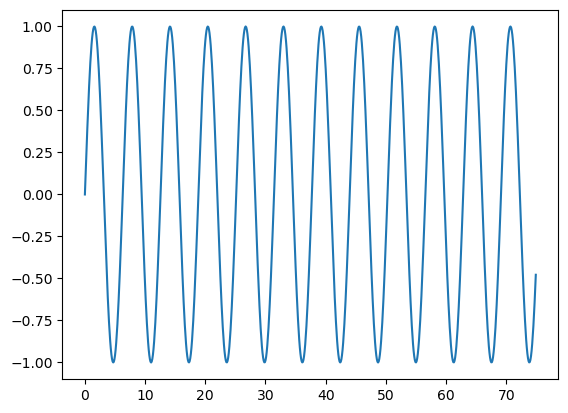

In [1]:
# Generate sine wave data
import torch
import matplotlib.pyplot as plt
import numpy as np

window_size = 15
dt = 0.1
tmax = 75

# Training data
t_data = torch.arange(0, tmax, dt)
sine_wave = torch.sin(t_data).view(-1, 1)

# Testing data
t_ext = torch.arange(tmax, tmax + 100, dt)
sine_wave_ext = torch.sin(t_ext).view(-1, 1)

plt.plot(t_data, sine_wave)
plt.show()

Since the RNN is not good at learning a long sequence, we will chunk the sequence into shorter sequences, i.e.,

$$
X = \begin{bmatrix}
x_1 & x_2 & \cdots & x_{L} \\
x_2 & x_3 & \cdots & x_{L+1} \\
\vdots & \vdots & \ddots & \vdots \\
x_{T-L} & x_{T-L+1} & \cdots & x_{T-1}
\end{bmatrix}
\quad
y = \begin{bmatrix}
x_{L+1} \\
x_{L+2} \\
\vdots \\
x_{T}
\end{bmatrix}
$$

In [2]:
def to_sliding_window_form(sine_wave, window_size):
    X, y = [], []
    for _t in range(len(sine_wave)-window_size-1):
        # Input is current window
        X.append(sine_wave[_t:_t+window_size])
        # Target is next single value
        y.append(sine_wave[_t+window_size])

    X = torch.stack(X)  # Shape: (n_samples, window_size, 1)
    y = torch.stack(y).unsqueeze(1)  # Shape: (n_samples, 1, 1)
    return X, y

X_train, y_train = to_sliding_window_form(sine_wave, window_size)
print("Shape of X_train (number of samples, sequence length, feature size):", X_train.shape)
print("Shape of y_train (number of samples, sequence length, feature size):", y_train.shape)

Shape of X_train (number of samples, sequence length, feature size): torch.Size([734, 15, 1])
Shape of y_train (number of samples, sequence length, feature size): torch.Size([734, 1, 1])


We will create a simple dataloader for the training data using Pytorch.
The key data modules in Pytorch are *Dataset* and *Dataloader*. *Dataset* is a wrapper of the data with some common functions. *Dataloader* takes care of *batching* the data, *shuffling* the data, and *loading* the data.

We will create the dataset from the torch array using `torch.utils.data.TensorDataset`. We then split the dataset into training and validation datasets using `torch.utils.data.random_split`. Finally, we create the dataloader for the training and validation datasets using `torch.utils.data.DataLoader`.

In [3]:
# Create a dataset
dataset = torch.utils.data.TensorDataset(X_train, y_train)

# Split the dataset into training and validation datasets
train_dataset_sz = int(len(dataset) * 0.8)
val_dataset_sz = len(dataset) - train_dataset_sz
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset,
    [train_dataset_sz, val_dataset_sz],
    generator=torch.Generator().manual_seed(42),
)

# Create a dataloader for the training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Create a dataloader for the validation dataset
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)

```{tip}
The train and validation datasets are mutually exclusive subsets of the original dataset. The train dataset is used for training the model, while the validation dataset is used for evaluating the model.
It is often useful to keep track of the validation loss during training to stop the training when the validation loss stops improving. This helps to prevent overfitting and save computational resources.
```

Let us now define the RNN model. We will use [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) to define the model.

In [4]:
import pytorch_lightning as pyl
import torch
from typing import Tuple


class AutoRegressiveRNN(pyl.LightningModule):
    """A simple RNN model that processes sequences one timestep at a time."""

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Define the two key transformations of RNN
        self.i2h = torch.nn.Linear(
            input_size + hidden_size, hidden_size
        )  # input to hidden
        self.i2o = torch.nn.Linear(
            input_size + hidden_size, output_size
        )  # input to output
        self.tanh = torch.nn.Tanh()  # activation function

        self.val_losses = []

    def forward(self, input: torch.Tensor, hidden: torch.Tensor):
        """Forward pass of the RNN model."""
        batch_size, seq_length, _ = input.size()
        outputs = torch.zeros(
            batch_size, seq_length, self.i2o.out_features, device=self.device
        )

        # Process sequence
        for t in range(seq_length):
            # Combine current input with previous hidden state
            combined = torch.cat((input[:, t, :], hidden), 1)

            # Update hidden state and compute output
            hidden = self.tanh(self.i2h(combined))
            outputs[:, t, :] = self.i2o(combined)

        return outputs.squeeze(1) if seq_length == 1 else outputs, hidden

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs, _ = self.forward(x, self.init_hidden(x.size(0)))
        last_output = outputs[:, -1, :]

        loss = torch.nn.functional.mse_loss(last_output.reshape(-1), y.reshape(-1))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            x, y = batch
            outputs, _ = self.forward(x, self.init_hidden(x.size(0)))
            last_output = outputs[:, -1, :]

            loss = torch.nn.functional.mse_loss(last_output.reshape(-1), y.reshape(-1))
            self.log("val_loss", loss, on_epoch=True)
            self.val_losses.append(loss.cpu().item())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

    def init_hidden(self, batch_size: int = 1) -> torch.Tensor:
        """Initialize hidden state with zeros."""
        return torch.zeros(batch_size, self.hidden_size, device=self.device)


model = AutoRegressiveRNN(input_size=1, hidden_size=10, output_size=1)

```{tip}
PyTorch Lightning is a framework that provides a high-level interface for training and evaluating PyTorch models. It provides a lot of useful functions for training and evaluating the model, such as `train()`, `val()`, `test()`, `fit()`, `predict()`, etc.
```

In [5]:
trainer = pyl.Trainer(
    max_epochs=50, # Number of epochs to train the model
    enable_progress_bar=False, # Whether to show the progress bar
    enable_model_summary=False # Whether to show the model summary
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


`Trainer.fit` stopped: `max_epochs=50` reached.


To see how the model performs, we can plot the validation loss during training.

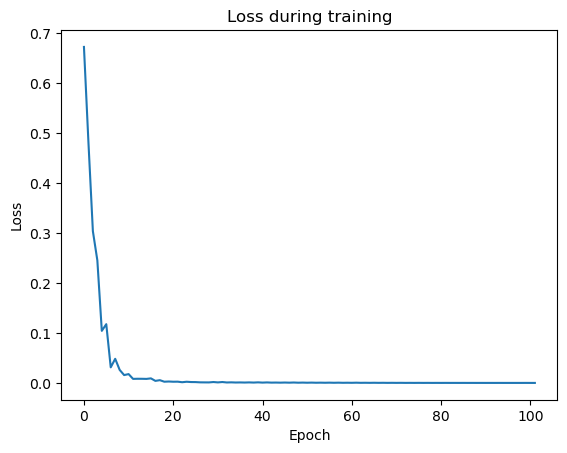

In [6]:
plt.plot(model.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.show()

```{warning}
Always label the axes!!!! It is very common that a figure is not self-explanatory due to the lack of labels.
```

Now, let us use the trained model to extrapolate the sine wave.

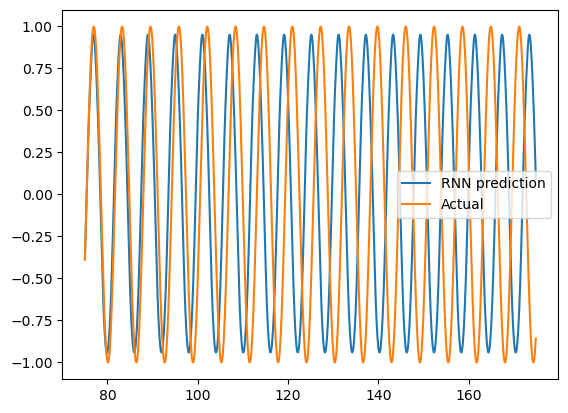

In [7]:
model.eval()
pred_seq = sine_wave[-window_size:].view(-1).tolist()
for _t in range(len(t_ext)):
    # Feed the window sequence to the RNN
    hidden = model.init_hidden(batch_size=1)
    x_t = torch.tensor(pred_seq[_t : _t + window_size]).reshape(
        1, -1, 1
    )  # This is a 1D tensor of shape (sequence_length,)
    output, hidden = model(x_t, hidden)
    pred_seq.append(output[0, -1, 0].item())

pred_seq = torch.tensor(pred_seq)[window_size:]
plt.plot(t_ext, pred_seq, label="RNN prediction")
plt.plot(t_ext, sine_wave_ext, label="Actual")
plt.legend()
plt.show()

We observed that the RNN is able to predict the sine wave with a reasonable accuracy, with errors increasing over time. This is because, at each time step, the RNN made some errors, which were accumulated over time, resulting in a larger error.

## 🔥 Exercise 🔥

1. Turn off the gradient clipping and see how the model performs.

2. Try to predict the sine wave with a longer sequence

3. Change the sequence length and see how the model performs.

4. Create a new dataset and see how the model performs.